In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load dataset
heart_disease = fetch_ucirepo(id=45)  # Cleveland Heart Disease dataset

# Convert the dataset to a DataFrame
df = pd.DataFrame(heart_disease.data.features, columns=heart_disease.data.feature_names)
df['num'] = heart_disease.data.targets  # Assuming target column name is 'num'

# Rename columns if necessary
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'num'
]
df.columns = column_names

# Replace '?' or '' with NaN and convert columns to numeric
df.replace(['?', ''], np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the median
for col in ['ca', 'thal', 'oldpeak', 'slope']:
    df[col].fillna(df[col].median(), inplace=True)

# Simplify the target column to binary
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

# One-hot encoding for categorical columns
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Split data into features and target
X = df.drop('target', axis=1).values
y = df['target'].values

# Print the shape of features and target to confirm
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (303, 20)
Shape of y: (303,)


/var/folders/57/wjb58jbn0tlbgrnz99_75crc0000gn/T/ipykernel_50493/1337968598.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
class HeartDiseaseDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
train_dataset = HeartDiseaseDataset(X_train, y_train)
test_dataset = HeartDiseaseDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16)


In [ ]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)

# Initialize the model
input_dim = X_train.shape[1]
model = HeartDiseaseModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 100
patience = 10
best_loss = np.inf
counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).view(-1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.tensor(X_test, dtype=torch.float32)).view(-1)
        val_loss = criterion(val_outputs, torch.tensor(y_test, dtype=torch.float32)).item()
        val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(best_model_state)


Epoch [1/100], Train Loss: 0.6925, Val Loss: 0.6819
Epoch [2/100], Train Loss: 0.6567, Val Loss: 0.6576
Epoch [3/100], Train Loss: 0.6493, Val Loss: 0.6298
Epoch [4/100], Train Loss: 0.6050, Val Loss: 0.5908
Epoch [5/100], Train Loss: 0.5837, Val Loss: 0.5466
Epoch [6/100], Train Loss: 0.5432, Val Loss: 0.4932
Epoch [7/100], Train Loss: 0.4887, Val Loss: 0.4482
Epoch [8/100], Train Loss: 0.4525, Val Loss: 0.4191
Epoch [9/100], Train Loss: 0.4498, Val Loss: 0.3916
Epoch [10/100], Train Loss: 0.4324, Val Loss: 0.3733
Epoch [11/100], Train Loss: 0.4134, Val Loss: 0.3628
Epoch [12/100], Train Loss: 0.3713, Val Loss: 0.3611
Epoch [13/100], Train Loss: 0.3944, Val Loss: 0.3668
Epoch [14/100], Train Loss: 0.3902, Val Loss: 0.3698
Epoch [15/100], Train Loss: 0.3661, Val Loss: 0.3693
Epoch [16/100], Train Loss: 0.3417, Val Loss: 0.3671
Epoch [17/100], Train Loss: 0.3556, Val Loss: 0.3628
Epoch [18/100], Train Loss: 0.3456, Val Loss: 0.3646
Epoch [19/100], Train Loss: 0.3224, Val Loss: 0.3631
Ep

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        33
           1       0.81      0.75      0.78        28

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



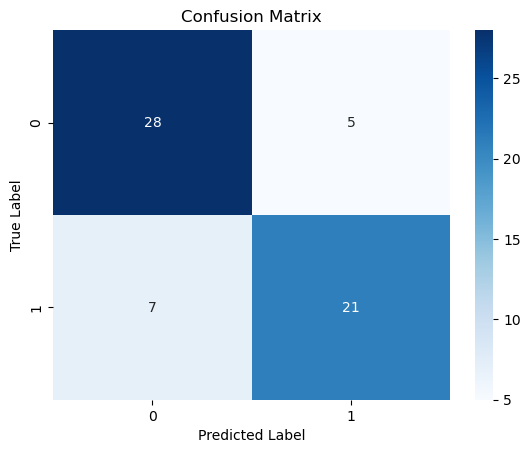

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(torch.tensor(X_test, dtype=torch.float32)).view(-1).numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


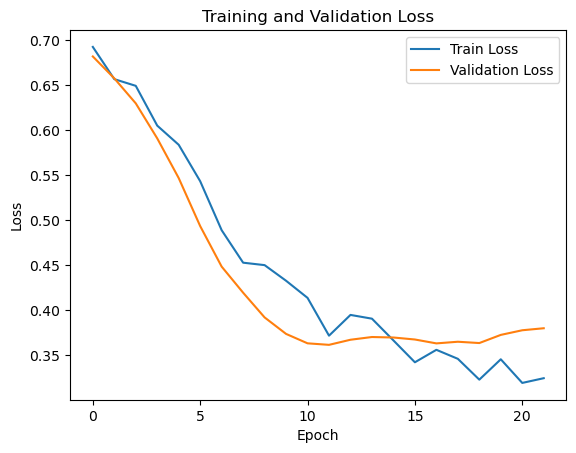

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
